In [1]:
import glob
from ms2lda_feature_extraction import LoadMSP, LoadGNPS, LoadMGF

In [2]:
# # input_file = '../data/MSMS-NIST-Curated-Pos-MfKit.msp'
# input_file = '../data/MoNA-export-LC-MS-MS_Positive_Mode.msp'
# l = LoadMSP()
# ms1,ms2,metadata = l.load_spectra([input_file])

In [3]:
input_file = '../data/ALL_GNPS.mgf'
l = LoadMGF()
ms1,ms2,metadata = l.load_spectra([input_file])

In [4]:
# toremove = []
# for m in ms1:
#     md = metadata[m.name]
#     if int(md['charge']) < 0:
#         toremove.append(m)
# print("Found {} with -ve charge".format(len(toremove)))

# for m in toremove:
#     del metadata[m.name]
#     pos = ms1.index(m)
#     del ms1[pos]

In [5]:
# def make_spec_dict(ms2):
#     spec_dict = {}
#     for m in ms2:
#         ms1 = m[3]
#         ms1_name = ms1.name
#         if not ms1_name in spec_dict:
#             spec_dict[ms1_name] = []
#         frag_mz = m[0]
#         frag_intensity = m[1]
#         spec_dict[ms1_name].append((m[0],m[2]))
#     # sort them
#     for m in spec_dict:
#         spec_dict[m] = sorted(spec_dict[m],key = lambda x: x[0])
        
#     # normalise intensities
#     for m in spec_dict:
#         max_val = max([x[1] for x in spec_dict[m]])
#         new_spec = []
#         for mz,i in spec_dict[m]:
#             new_spec.append((mz,100.0*i/max_val))
#         spec_dict[m] = new_spec
#     return spec_dict

# spec_dict_gnps = make_spec_dict(ms2)

In [6]:
min_frag_mz = 20
max_frag_mz = 500
import numpy as np

In [7]:
def make_spec_matrix(ms1,ms2,min_frag_mz = 20,max_frag_mz = 500,normalise = 1000.0):
    doc_index = {}
    n_docs = len(ms1)
    i = 0
    for m in ms1:
        doc_index[m.name] = i
        i += 1
    n_words = max_frag_mz - min_frag_mz + 1
    n_docs = len(doc_index)
    doc_matrix = np.zeros((n_docs,n_words),np.double)
    for m in ms2:
        mz = m[0]
        mz_int = (int)(np.round(mz))
        doc_pos = doc_index[m[3].name]
        if mz_int <= max_frag_mz and mz_int >= min_frag_mz:
            mz_pos = mz_int - min_frag_mz
            doc_matrix[doc_pos,mz_pos] += m[2]
    s = doc_matrix.sum(axis=1)
    toremove = []
    for doc,doc_pos in doc_index.items():
        if s[doc_pos] == 0:
            toremove.append(doc)
    
    for doc in toremove:
        doc_pos = doc_index[doc]
        doc_matrix = np.delete(doc_matrix,(doc_pos),axis=0)
        del doc_index[doc]
        for d,p in doc_index.items():
            if p > doc_pos:
                doc_index[d] -= 1
    
    if normalise > 0:
        s = doc_matrix.max(axis=1)
        s = s[:,None]
        doc_matrix *= (normalise/s)

        
    
    return doc_index,doc_matrix
        

In [8]:
doc_index,doc_matrix = make_spec_matrix(ms1,ms2)

In [31]:
test_doc = list(doc_index.keys())[3456]
print(test_doc)

document_3504


In [9]:
test_doc = list(doc_index.keys())[3456]
pos = np.where(doc_matrix[doc_index[test_doc],:]>0)[0]
print(metadata[test_doc])
for p in pos:
    print(p+20,doc_matrix[doc_index[test_doc],p])

{'parentmass': 293.21, 'parentintensity': None, 'charge': '1', 'mslevel': '2', 'source_instrument': 'LC-ESI-qTof', 'filename': 'TerbinafineHCl.mgf', 'seq': '*..*', 'ionmode': 'Positive', 'organism': 'GNPS-SELLECKCHEM-FDA-PART1', 'name': 'TerbinafineHCl M+H', 'pi': 'Sirenas', 'datacollector': 'Ed Esquenazi', 'smiles': 'N/A', 'inchi': 'N/A', 'inchiaux': 'N/A', 'pubmed': 'N/A', 'submituser': 'mwang87', 'libraryquality': '3', 'spectrumid': 'CCMSLIB00000005027', 'scans': '4'}
101 0.04590070702630794
103 0.5490336510870657
104 0.045244984085488014
105 9.367511352286844
106 6.635511977798805
107 0.214414292845789
108 1.0141542778603068
109 0.509976636619946
110 0.8087766891341607
115 1.709012011808077
116 1.5576116468140566
117 0.6017561037629175
119 2.239230457203396
120 2.7162046543897893
121 22.900444770301526
122 15.825138515017011
123 0.6961097869325672
124 0.1850399460112724
125 0.24955626595209873
126 0.08801695478081048
130 0.20486704992085195
133 0.044780686218276446
134 0.1000936903

In [12]:
doc_matrix

array([[  0.        ,   0.        ,   0.        , ..., 110.86230454,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
         45.29090614,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        663.46139993,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [13]:
s = doc_matrix.max(axis=1)[:,None]
train_data = np.log(doc_matrix+1)

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.objectives import categorical_crossentropy
from keras.constraints import nonneg
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras.datasets import mnist

Using TensorFlow backend.


In [15]:
from keras.constraints import nonneg
from keras.layers import Input, Dense, Lambda
from keras.models import Model

n_in = train_data.shape[1]
print(n_in)
af = 'relu'
input_layer = Input(shape = (train_data.shape[1],))
l = input_layer
l = Dense(256,activation = af)(l)
l = Dense(128,activation = af)(l)
# l = Dense(16,activation= af(l)
l = Dense(16)(l)
# l = Dense(2)(l)

proj_layer = l

# l2 = Dense(16,activation = af)(l)
l2 = Dense(128,activation = af)(l)
l2 = Dense(256,activation = af)(l2)
l2 = Dense(n_in,activation = af)(l2)


out_layer = l2

auto_model = Model(input = input_layer,output = out_layer)

sgd = SGD(lr = 0.1)
auto_model.compile(loss='mean_squared_error',optimizer = sgd)


481


/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [23]:
auto_model.fit(train_data,train_data,nb_epoch = 100)

Epoch 1/100
1120/9242 [==>...........................] - ETA: 1s - loss: 0.5334

/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  if __name__ == '__main__':


9242/9242 [==============================] - 1s 132us/step - loss: 0.5393
Epoch 2/100
9242/9242 [==============================] - 1s 125us/step - loss: 0.5384
Epoch 3/100
9242/9242 [==============================] - 1s 125us/step - loss: 0.5377
Epoch 4/100
9242/9242 [==============================] - 1s 125us/step - loss: 0.5362
Epoch 5/100
9242/9242 [==============================] - 1s 126us/step - loss: 0.5338
Epoch 6/100
9242/9242 [==============================] - 1s 127us/step - loss: 0.5367
Epoch 7/100
9242/9242 [==============================] - 1s 136us/step - loss: 0.5346
Epoch 8/100
9242/9242 [==============================] - 1s 160us/step - loss: 0.5383
Epoch 9/100
9242/9242 [==============================] - 1s 146us/step - loss: 0.5344
Epoch 10/100
9242/9242 [==============================] - 1s 132us/step - loss: 0.5312
Epoch 11/100
9242/9242 [==============================] - 1s 130us/step - loss: 0.5313
Epoch 12/100
9242/9242 [==============================] - 1s 130

In [24]:
proj_model = Model(input = input_layer,output = proj_layer)

/Users/joewandy/anaconda/envs/smiles2spectra/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [25]:
projections = proj_model.predict(train_data)

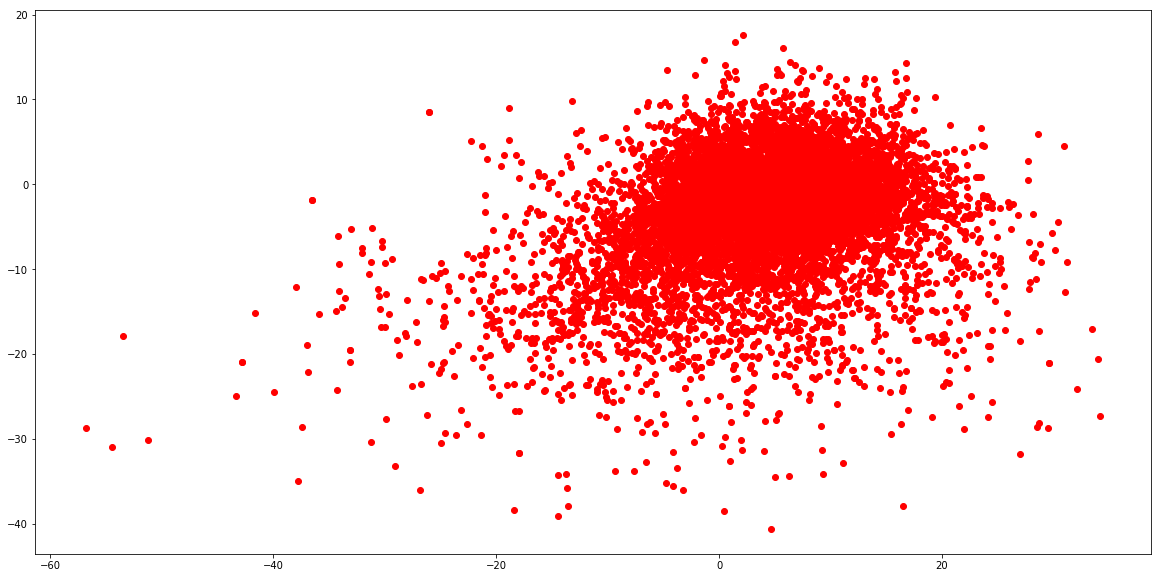

In [26]:
plt.figure(figsize=(20,10))
plt.plot(projections[:,0],projections[:,1],'ro')

In [27]:
def plot_random_spec(train_data,auto_model,min_frag_mz):
    outputs = auto_model.predict(train_data)
    n_spec = train_data.shape[0]
    spec_idx = np.random.choice(n_spec)
    pos = np.where(train_data[spec_idx,:]>0)[0]
    plt.figure(figsize=(20,5))
    for p in pos:
        plt.plot([p+min_frag_mz,p+min_frag_mz],[0,train_data[spec_idx,p]],'b')
    pos = np.where(outputs[spec_idx,:]>0)[0]
    for p in pos:
        plt.plot([p+min_frag_mz,p+min_frag_mz],[0,-outputs[spec_idx,p]],'r')

    

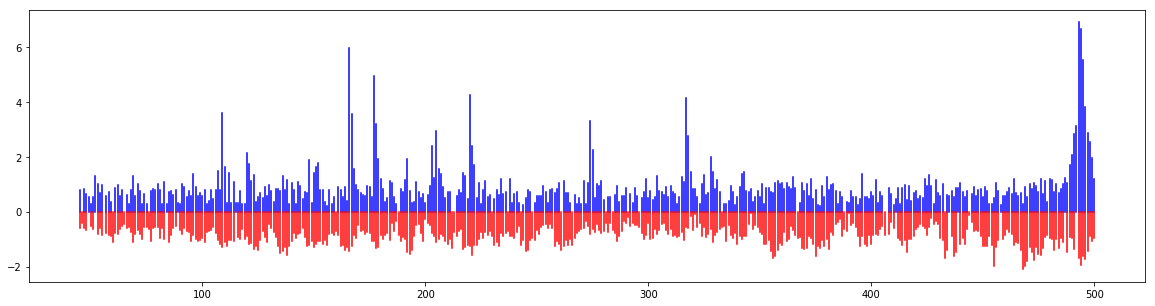

In [28]:
plot_random_spec(train_data,auto_model,20)

Inverse model

In [ ]:
from functools import reduce

In [ ]:
# we also create the inverse model
latent_input = Input(shape=(16,))
decoder_layers = auto_model.layers[-3:]

# surely this can't be the right way of doing this?!
decoder = reduce(lambda x,y:y(x), decoder_layers, latent_input)
inverse_model = Model(input=latent_input, output=decoder)





In [ ]:
def random_interpolation(proj_model,train_data,inverse_model,n_steps=10):
    projections = proj_model.predict(train_data)
    n_spec = train_data.shape[0]
    spec1 = np.random.choice(n_spec)
    spec2 = np.random.choice(n_spec)
    
    proj1 = projections[spec1,:]
    proj2 = projections[spec2,:]
    
    diff = proj2 - proj1
    deltas = diff/n_steps
    test_out = inverse_model.predict(projections)
    steps = [test_out[spec1,:]]
    for i in range(n_steps):
        proj1 += deltas
        temp = inverse_model.predict(proj1[None,:]).T
        steps.append(temp)
    steps.append(test_out[spec2,:])
    return steps
    

In [ ]:
steps = random_interpolation(proj_model,train_data,inverse_model,n_steps=20)

In [ ]:
start = steps[0]
end = steps[-1]
plt.figure(figsize=(20,5))
pos = np.where(start>0)[0]
for p in pos:
    plt.plot([p+20,p+20],[0,start[p]],'b')
pos = np.where(end>0)[0]
for p in pos:
    plt.plot([p+20,p+20],[0,-end[p]],'r')
plt.xlim([0,500])



In [ ]:
for i,step in enumerate(steps):
    if i == 0 or i == len(steps)-1:
        c = 'r'
    else:
        c = 'b'
    plt.figure(figsize=(20,2))
    pos = np.where(step>0)[0]
    for p in pos:
        plt.plot([p+20,p+20],[0,step[p]],c)
    plt.xlim([0,500])